In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import smplotlib
from numpy.random import *
import secrets

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
from scipy.optimize import curve_fit
import time
import pandas as pd

In [2]:
seed = secrets.randbits(128)
rng_default = np.random.default_rng(seed)

### González Lópezlira et al. (2019) have identified 16 Globular Clusters around the late-type galaxy NGC 4258 (M106).
### Ref: https://arxiv.org/abs/1904.02712

In [3]:
df = pd.read_table('GonzalezLopezlira2019_GCs.dat')

In [9]:
GC_names = df['Name'][2:].to_numpy(dtype=str)
RA = df['R.A. J2000'][2:].to_numpy(dtype=float)
dec = df['Decl. J2000'][2:].to_numpy(dtype=float)
v_proj = df['V_proj'][2:].to_numpy(dtype=float)
dv_proj = df['DeltaV_proj'][2:].to_numpy(dtype=float)

RA_galaxycenter = (12 + (18 + 57.505/60)/60) * 360/24
dec_galaxycenter = 47 + (18 + 14.304/60)/60
Pos_angle = np.deg2rad(150)

In [6]:
RA_galaxycenter, RA, dec_galaxycenter, dec

(184.73960416666668,
 array([184.7166, 184.7205, 184.7266, 184.7345, 184.7384, 184.75  ,
        184.7553, 184.7565, 184.7585, 184.7622, 184.7624, 184.7847,
        184.8578, 184.8685, 184.8711, 184.8944]),
 47.30397333333333,
 array([47.2335, 47.3672, 47.3885, 47.2366, 47.3918, 47.352 , 47.3166,
        47.3183, 47.3469, 47.3572, 47.3453, 47.2322, 47.2079, 47.1978,
        47.2042, 47.2212]))

### The claim is that the system of GC’s presents rotation around the Galaxy minor axis (Position angle = 150°).
### The Galaxy center is at:
### ${\rm R.A.} = 12^{\rm h}18^{\rm m}57.505^{\rm s}$, ${\rm Dec.} = +47^\circ 18' 14.304''$
### Its photometric axis ratio is $0.389$.
### At the galaxy’s distance ($7.6 ~ {\rm Mpc}$), an ${\rm arcsecond}$ is $36.75 ~ {\rm pc}$.

### Design a Monte Carlo experiment to quantify the statistical significance of this claim.

#### The null hypothesis will be that there is no rotation.
#### Identify a suitable diagnostic to measure and find its PDF under the null hypothesis, by using Monte Carlo realizations. From this, find the p-value of the observed data and accept, or reject, the claim at some significance level.

### Notice that we only want to test the claim that the GC system rotates, not whether it does in some particular way, or to measure a rotation velocity, i.e. our test should be non-parametric.

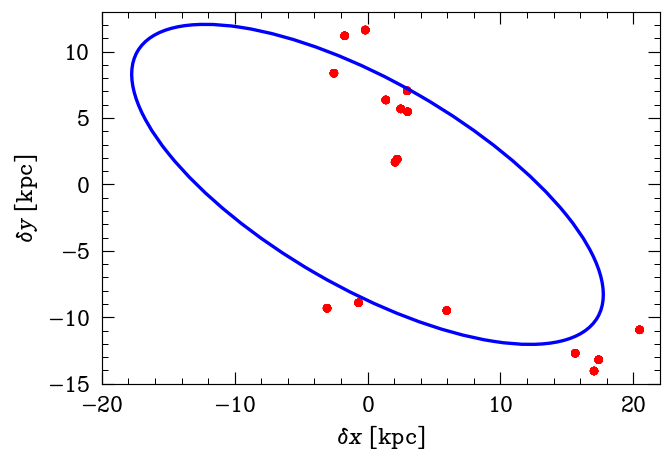

In [65]:
dx_kpc = (RA-RA_galaxycenter)*3600*36.75 / 1e3
dy_kpc = (dec-dec_galaxycenter)*3600*36.75 / 1e3

fig, ax = plt.subplots()
ax.set_xlabel(r'$\delta x$ [kpc]')
ax.set_ylabel(r'$\delta y$ [kpc]')
for i in range(len(RA)):
    ax.scatter(dx_kpc, dy_kpc, edgecolor='none', s=25, c='r')

ellipse = Ellipse(xy=(0, 0), width=40, height=15.5, angle=np.rad2deg(Pos_angle),
                  edgecolor='blue', facecolor='none', lw=2)
ax.add_patch(ellipse)

ax.set_xlim(-20, 22)
ax.set_ylim(-15, 13)
ax.set_aspect('equal')

We apply a rotation of $150^\circ$:

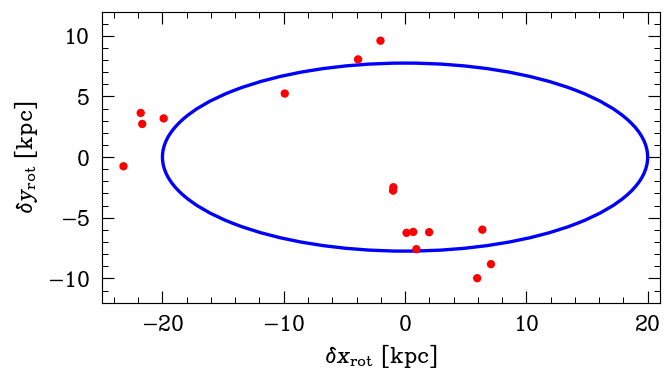

In [63]:
rotation_matrix = np.array([
    [np.cos(-Pos_angle), -np.sin(-Pos_angle)],
    [np.sin(-Pos_angle),  np.cos(-Pos_angle)]
])

pos_kpc = np.array([dx_kpc, dy_kpc]).T
pos_rot_kpc = rotation_matrix @ pos_kpc.T

dx_rot_kpc, dy_rot_kpc = pos_rot_kpc

fig, ax = plt.subplots()
ax.set_xlabel(r'$\delta x_{\rm rot}$ [kpc]')
ax.set_ylabel(r'$\delta y_{\rm rot}$ [kpc]')

ellipse = Ellipse(xy=(0, 0), width=40, height=15.5,
                  edgecolor='blue', facecolor='none', lw=2)
ax.add_patch(ellipse)

ax.scatter(dx_rot_kpc, dy_rot_kpc, edgecolor='none', s=25, c='r')

ax.set_xlim(-25, 21)
ax.set_ylim(-12, 12)
ax.set_aspect('equal')

We now compute $\langle v_{\rm los} \rangle$ and plot the resulting peculiar velocity vs. the coordinate along the major axis

(-250.0, 350.0)

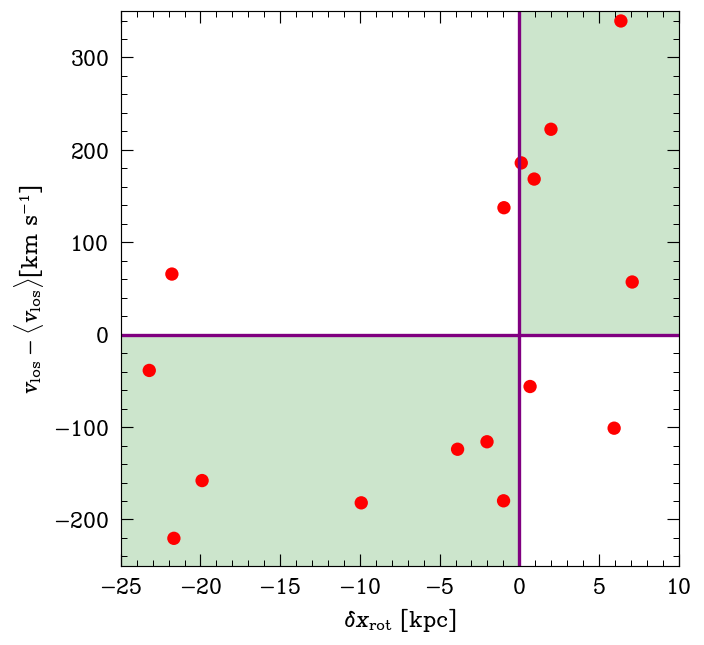

In [81]:
v_los_avg = np.mean(v_proj)
dv_los = v_proj - v_los_avg

fig, ax = plt.subplots()
ax.set_xlabel(r'$\delta x_{\rm rot}$ [kpc]')
ax.set_ylabel(r'$v_{\rm los} - \langle v_{\rm los} \rangle [{\rm km~s}^{-1}]$')

ax.axhline(0, lw=2, c='purple')
ax.axvline(0, lw=2, c='purple')
# Fill the quadrant
ax.fill_between([0, 15], [0, 0], [400, 400], color='g', alpha=0.2)
ax.fill_between([-30, 0], [-300, -300], [0, 0], color='g', alpha=0.2)

ax.scatter(dx_rot_kpc, dv_los, edgecolor='none', c='r')
ax.set_xlim(-25, 10)
ax.set_ylim(-250, 350)

It is clear that GC's that appear in opposite quadrants in this plot, rotate around the Galaxy's minor axis. In this case, rotation seems to occur on the quadrants:
\begin{eqnarray}
    \delta x_{\rm rot} > 0 ~~ \& ~~ \delta v_{\rm los} > 0,~~{\rm and} \\
    \delta x_{\rm rot} < 0 ~~ \& ~~ \delta v_{\rm los} < 0.
\end{eqnarray}

This signals rotation without any assumption as to the specific form of rotation

Diagnostic fo rotation: the fraction of GC's whose $\delta x_{\rm rot} \times \delta v_{\rm los} > 0$.

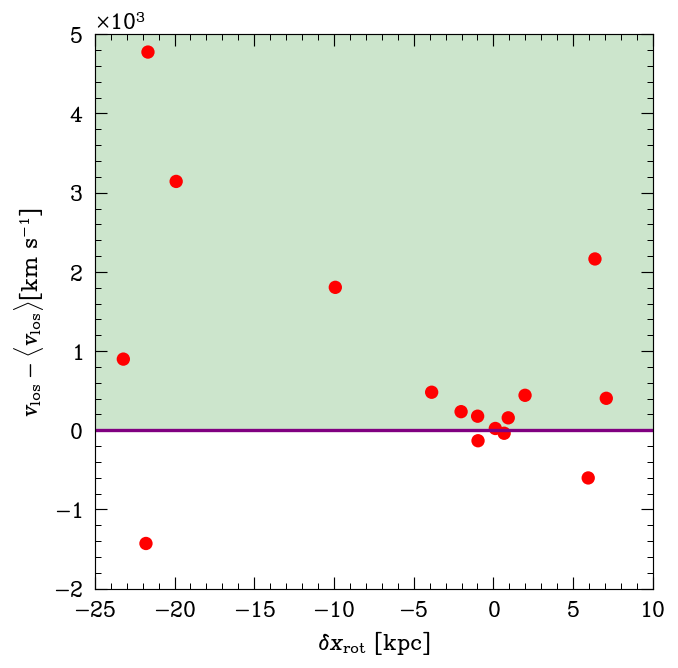

In [87]:
v_los_avg = np.mean(v_proj)
dv_los = v_proj - v_los_avg

fig, ax = plt.subplots()
ax.set_xlabel(r'$\delta x_{\rm rot}$ [kpc]')
ax.set_ylabel(r'$v_{\rm los} - \langle v_{\rm los} \rangle [{\rm km~s}^{-1}]$')

ax.axhline(0, lw=2, c='purple')
# Fill the quadrant
ax.fill_between([-26, 15], [0, 0], [6000, 6000], color='g', alpha=0.2)

ax.scatter(dx_rot_kpc, dv_los*dx_rot_kpc, edgecolor='none', c='r')
ax.set_xlim(-25, 10)
ax.set_ylim(-2000, 5000)

GC_rot = np.sum(dv_los*dx_rot_kpc > 0)
Fraction_GC_rot = GC_rot / len(dv_los)

There are $12$ out of $16$ GC's which satisfy this condition; that is, a fraction of $12/16 = 0.75$.

Under the NH (no rotation), the expected fraction is $0.5$.

Then, what is the probability of getting a fraction of $0.75$ under the NH for a sample of this size?

In [106]:
M = 1000000
N = 16
nbins = 50

def Random_coin(N, rng=rng_default):
    coin = rng.integers(0, 2, N)
    return coin

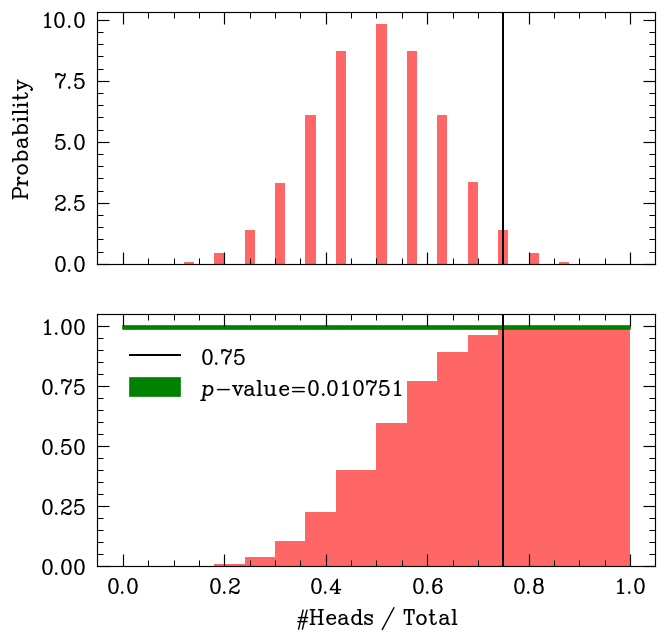

In [123]:
f_coins = np.zeros(M)
for i in range(M):
    R_coins = Random_coin(N)
    f_coins[i] = np.sum(R_coins == 1)/len(R_coins)

fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].set_ylabel(r'Probability')

axes[0].hist(f_coins, bins=nbins, range=(0, 1), density=True, alpha=0.6, color='r')
axes[0].axvline(Fraction_GC_rot, label=r'$0.75$')

axes[1].hist(f_coins, bins=nbins, cumulative=True, density=True, alpha=0.6, color='r')
axes[1].set_xlabel(r'$\# {\rm Heads}$ / Total')
axes[1].axvline(Fraction_GC_rot, label=r'$0.75$')

p_value = np.sum(f_coins > 0.75)/len(f_coins)
axes[1].fill_between([0, 1], [1-p_value, 1-p_value], [1.0, 1.0], color='g', label=r'$p$-value=' + str(p_value))
axes[1].legend()

Then, at $1.075 \%$ significance level, we can reject the NH. In other words, we can say that the GC's of this galaxy are consisten with having rotation around the Galaxy with a $98.925\%$ confidence level.